#### in 2015 the idea of making a computer system that can recignise birds was really challenging , but today we can do it in just a few minutes

## Step 1: Download images of birds and non-birds

In [ ]:
from duckduckgo_search import DDGS #Enable image search using duckduckgo API
from fastcore.all import * #a library made by fastai that have several feature and make programming easier
def search_images(keywords, max_images=500): # a function for changing and finding images and store the result(key words and Url) in the fastcore.L obgect
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image') #itemgot remove "image" grom each dictionery

### searching for a bird photo

In [ ]:
urls = search_images('dog photo', max_images=1)
url = urls[0]
print(url)

https://images.pexels.com/photos/257540/pexels-photo-257540.jpeg?cs=srgb&dl=pexels-pixabay-257540.jpg&fm=jpg


### downloadin and showing the photo

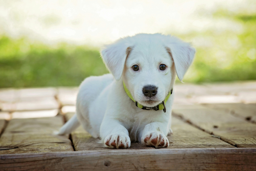

In [ ]:
from fastdownload import download_url #download an url  
name = 'dog.jpg' #name our file 
download_url(urls[0], name, show_progress=True)

from fastai.vision.all import * #fastai computer vision module 
im = Image.open(name) #open the saved the image 
im.to_thumb(256,256) #create a thumbnail of the photo 

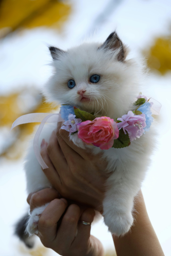

In [ ]:
download_url(search_images('cat photos', max_images=1)[0], 'cat.jpg', show_progress=True)
Image.open('cat.jpg').to_thumb(256,256)

In [ ]:
searches = 'dog','cat'
path = Path('dog_or_cat') #this define two folder in this path

for o in searches:
    dest = (path/o) #for each elenent in searches make a subdirectory
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo')) #downl oad images 
    time.sleep(5) #wair for 5 second between each requests
    resize_images(path/o, max_size=400, dest=path/o) #resize all the images

#### remove failes photos

In [ ]:
failed = verify_images(get_image_files(path)) #scans the path directory and detect if any iamage is failed then stored them in failed list
failed.map(Path.unlink) #soring an a diffrent method them remove them from filesystem
len(failed)

41

## Step 2: Train our model

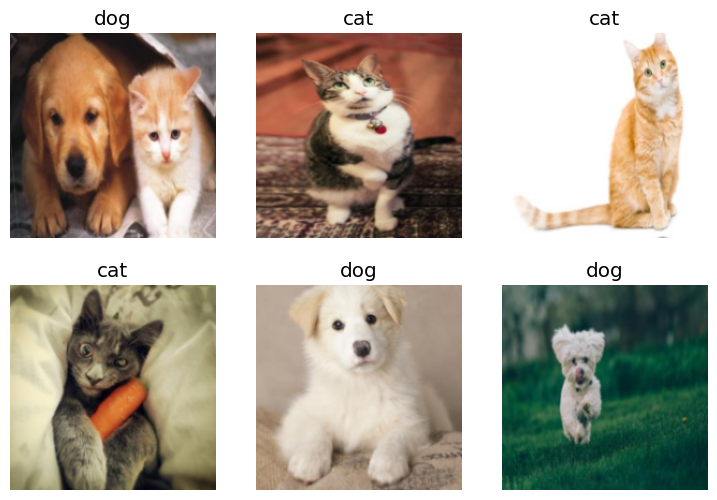

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #our input is image and our output is categorycal
    get_items=get_image_files, #tell fast ai to search for images 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split the data into test and validation(test) (80% training and 20% validation) , seed=42 ensure the function to five same split every time
    get_y=parent_label, #tell to get label from folder name 
    item_tfms=[Resize(192, method='squish')], #resize before using and squish the images for resizing
    batch_tfms=aug_transforms(mult=1.0)  # adds random flips, zoom, warp, lighting(Data Augmentation)
).dataloaders(path, bs=32) #make dataloaders from data blochs with batch size 32

dls.show_batch(max_n=6)#show a 6 random images from training data

In [ ]:
from fastai.losses import CrossEntropyLossFlat
from fastai.callback.tracker import EarlyStoppingCallback
learn = vision_learner(dls, resnet18, metrics=error_rate,loss_func=CrossEntropyLossFlat(label_smoothing=0.1))#use ResNet-18 pretrained model on our data and use error rate as metric 
learn.fine_tune(10,base_lr=1e-4,cbs=EarlyStoppingCallback(monitor='valid_loss', patience=3)) #doing this 10 pochs and if there was no decreaing for validation loss after 3 epoch stop 

epoch,train_loss,valid_loss,error_rate,time
0,0.978138,0.446530,0.141176,01:58


epoch,train_loss,valid_loss,error_rate,time
0,0.619366,0.423688,0.113725,02:55
1,0.582291,0.401086,0.082353,02:42
2,0.529026,0.373336,0.062745,02:40
3,0.504622,0.375968,0.052941,02:40
4,0.483242,0.369707,0.052941,02:41
5,0.464819,0.361660,0.050980,02:38
6,0.456946,0.354753,0.049020,02:36
7,0.446690,0.353950,0.049020,02:37
8,0.424745,0.348817,0.050980,03:05
9,0.427784,0.352092,0.050980,02:46


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

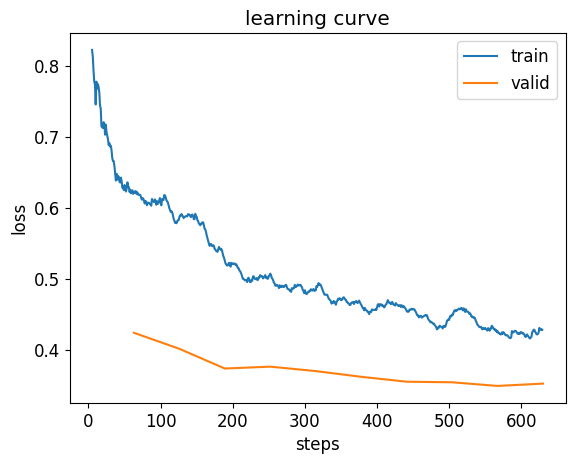

In [ ]:
learn.recorder.plot_loss()

In [ ]:
print(learn.recorder.values)

[[0.6193655729293823, 0.423688143491745, 0.11372549086809158], [0.5822910666465759, 0.4010862708091736, 0.08235294371843338], [0.5290259122848511, 0.3733355402946472, 0.062745101749897], [0.5046218037605286, 0.37596842646598816, 0.052941177040338516], [0.48324233293533325, 0.3697071969509125, 0.052941177040338516], [0.4648194909095764, 0.3616598844528198, 0.05098039284348488], [0.45694637298583984, 0.35475313663482666, 0.04901960864663124], [0.44669049978256226, 0.35395029187202454, 0.04901960864663124], [0.4247454106807709, 0.34881722927093506, 0.05098039284348488], [0.4277842342853546, 0.35209178924560547, 0.05098039284348488]]


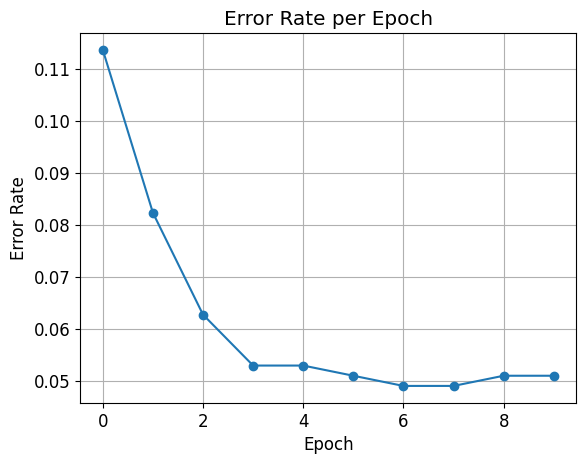

In [ ]:
import matplotlib.pyplot as plt

# Get all training history values (one list per epoch)
history = learn.recorder.values

# Extract the error rate (3rd value in each list) for every epoch
errors = []
for epoch_data in history:
    error = epoch_data[2]  # index 2 = error rate
    errors.append(error)
plt.plot(errors, marker='o')
plt.title("Error Rate per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.grid(True)
plt.show()

This is a: cat.
Probability it's a cat: 0.9967


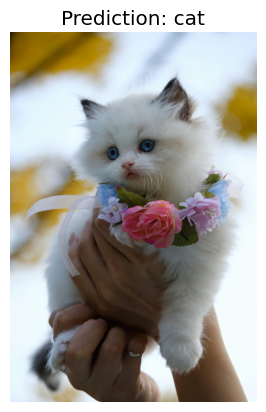

In [ ]:
is_cat, _, probs = learn.predict(PILImage.create('cat.jpg'))  # Load image and predict
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

# Show the image
import matplotlib.pyplot as plt
img = PILImage.create('cat.jpg')
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {is_cat}")
plt.show()


This is a: dog.
Probability it's a dog: 0.9591


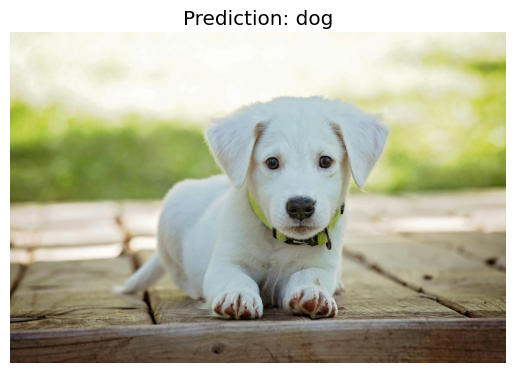

In [ ]:
is_dog, _, probs = learn.predict(PILImage.create('dog.jpg'))  # Load image and predict
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[1]:.4f}")

# Show the image
import matplotlib.pyplot as plt
img = PILImage.create('dog.jpg')
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {is_dog}")
plt.show()